In [280]:
import torch
import math
import matplotlib.pyplot as plt
from plyfile import PlyData
import numpy as np

In [281]:
data = PlyData.read('bunny/reconstruction/bun_zipper_res3.ply')
points_gt = torch.stack([
    torch.from_numpy(data.elements[0][axis])
    for axis in ['x', 'y', 'z']
]).T.unsqueeze(-1)

points_gt = points_gt - points_gt.mean(dim=0)

In [282]:
torch.manual_seed(0)
theta = torch.rand(1) * math.pi / 2 #why divide by 2?
phi = torch.rand(1) * 2 * math.pi

camera_Rx = torch.tensor([
    [1,                0,                 0],
    [0, torch.cos(theta), -torch.sin(theta)],
    [0, torch.sin(theta),  torch.cos(theta)],
])
camera_Ry = torch.tensor([
    [ torch.cos(phi), 0, torch.sin(phi)],
    [              0, 1,              0],
    [-torch.sin(phi), 0, torch.cos(phi)],
])

camera_R = camera_Rx@camera_Ry
camera_t = torch.tensor([[0],[0],[0.2]])

In [283]:
camera_points = camera_R@points_gt + camera_t

In [284]:
def distort(beta1, beta2, points):
  x = points[:,0,:]
  y = points[:,1,:]

  r2 = x**2 + y**2
  r4 = r2**2

  distort_x = x*(1+ beta1*r2+beta2*r4)
  distort_y = y*(1+ beta1*r2+beta2*r4)
  
  return torch.stack([distort_x, distort_y],dim = 1)

In [285]:
camera_points.shape

torch.Size([1889, 3, 1])

In [286]:
perspective_projection = camera_points[:,:-1,:]/(camera_points[:,-1,:].unsqueeze(1))

#distortion


beta1 = 1.0
beta2 = 0.0

distort_xy  = distort(1.0, 0.0,  perspective_projection)
ones = torch.ones((distort_xy.shape[0],1,1))
distort_xyz = torch.cat([distort_xy,ones],dim = 1)

# w = 1 for all xy 

camera_K = torch.tensor([
    [1.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])


projected_points = (camera_K@distort_xyz)

#divide by w

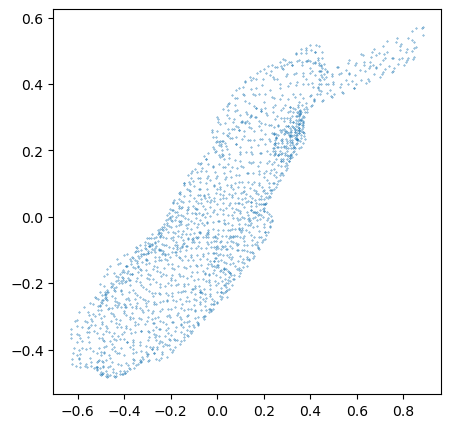

In [287]:
fig, axs = plt.subplots(1, figsize=(5, 5))

xpoints = projected_points[:,0].squeeze()
ypoints = projected_points[:,1].squeeze()
axs.scatter(xpoints,ypoints,s = 0.1)


In [288]:
# create 2 images with same intrinsic params but different extrinic params

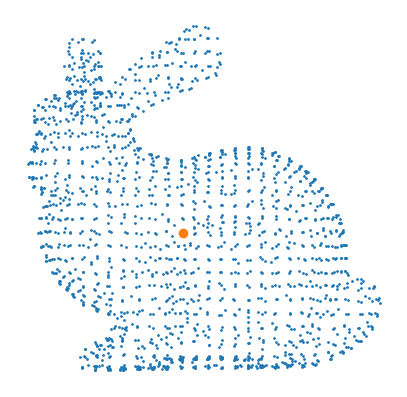

In [289]:
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_aspect(1.0)
ax.set_axis_off()
points_x, points_y, points_z = points_gt[:,:,:].squeeze().T
plt.scatter(points_x, points_y, s=1)
plt.scatter([0], [0])
plt.show()

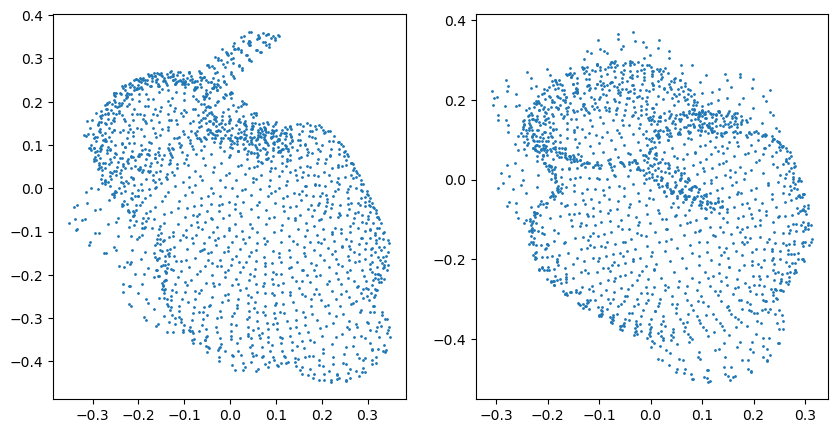

In [291]:
fig_2, axs = plt.subplots(1,2, figsize=(10, 5))

rotation_matrix = []
translation = []
points_list = []
depth = []
#same intrinsic params 
camera_K = torch.tensor([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
]) 
torch.manual_seed(0)
x_temp = []
y_temp = []
x_camera = []
y_camera=[]
camera_point_list = []
points = points_gt[:,:,:]
thetao = torch.rand(1) * math.pi / 2 #max 1/2 pi 
phio = torch.rand(1) * 2 * math.pi

for ax in axs.flatten():

  theta = thetao +np.random.random() #max 1/2 pi 
  phi =  phio+np.random.random()

  camera_Rx = torch.tensor([
      [1,                0,                 0],
      [0, torch.cos(theta), -torch.sin(theta)],
      [0, torch.sin(theta),  torch.cos(theta)],
  ])
  camera_Ry = torch.tensor([
      [ torch.cos(phi), 0, torch.sin(phi)],
      [              0, 1,              0],
      [-torch.sin(phi), 0, torch.cos(phi)],
  ])

  camera_R = camera_Rx@camera_Ry
#   print('camera_R')
  rotation_matrix.append(camera_R)
  camera_t = torch.tensor([[0],[0],[0.2]])
  translation = camera_t
  camera_points = camera_R@points + camera_t
  x_camera.append(camera_points[:,0,:])
  y_camera.append(camera_points[:,1,:])
  depth.append(camera_points[:,-1,:])
  # print(camera_points)
  camera_point_list.append(camera_points)
  perspective_projection = camera_points[:,:-1,:]/(camera_points[:,-1,:].unsqueeze(1))
  x_temp.append(perspective_projection[:,0])
  y_temp.append(perspective_projection[:,1])
  # print(perspective_projection[:,0])
  beta1 = 1.0
  beta2 = 0.0
  distort_xy  = distort(0.0, 0.0,  perspective_projection)
  ones = torch.ones((distort_xy.shape[0],1,1))
  distort_xyz = torch.cat([distort_xy,ones],dim = 1)
  # print(distort_xyz)

  projected_points = (camera_K@distort_xyz)
  # print(projected_points)
  xpoints = projected_points[:,0].squeeze()
  ypoints = projected_points[:,1].squeeze()
  ax.scatter(xpoints,ypoints,s = 1)

  points_list.append(projected_points)


In [292]:
#unprojection

In [293]:
point_distort_xyz_1 = torch.inverse(camera_K)@points_list[0]
point_distort_xyz_2 = torch.inverse(camera_K)@points_list[1]

In [294]:
# point_distort_xyz_1 #all w = 1 

In [295]:
from scipy.optimize import fsolve
def func(xy,beta1,beta2, distort_xy):
  
    x = xy[0:int(len(xy)/2)]
    y = xy[int(len(xy)/2):]
    r2 = np.array([x**2 + y**2,x**2 + y**2]).flatten()
    r4 = r2**2
  
    arr = []
    for i in range (len(xy)):
       arr.append(xy[i]*(1+ beta1*r2[i]+beta2*r4[i])-distort_xy[i])
     
    return arr


point_distort_x_1 = point_distort_xyz_1[:,0,:].squeeze().numpy()
point_distort_y_1 = point_distort_xyz_1[:,1,:].squeeze().numpy()
root_1 = fsolve(func, np.array([point_distort_x_1,point_distort_y_1]).flatten(), args = (1,0,np.array([point_distort_x_1,point_distort_y_1]).flatten()))
scaled_x_1 = root_1[:int(len(point_distort_x_1))]
scaled_y_1 = root_1[int(len(point_distort_y_1)):]
x_1 = scaled_x_1 *depth[0].squeeze().numpy()
y_1 = scaled_y_1 *depth[0].squeeze().numpy()


point_distort_x_2 = point_distort_xyz_2[:,0,:].squeeze().numpy()
point_distort_y_2 = point_distort_xyz_2[:,1,:].squeeze().numpy()
root_2 = fsolve(func, np.array([point_distort_x_2,point_distort_y_2]).flatten(), args = (1,0,np.array([point_distort_x_2,point_distort_y_2]).flatten()))
scaled_x_2 = root_2[:int(len(point_distort_x_2))]
scaled_y_2 = root_2[int(len(point_distort_y_2)):]
x_2 = scaled_x_2 *depth[1].squeeze().numpy()
y_2 = scaled_y_2 *depth[1].squeeze().numpy()


In [337]:
reconsturcted_1 = torch.from_numpy(np.stack((x_1,y_1,depth[0].squeeze().numpy())).T).unsqueeze(2)
reconsturcted_2 = torch.from_numpy(np.stack((x_2,y_2,depth[1].squeeze().numpy())).T).unsqueeze(2)

In [338]:
False in (reconsturcted_2 - camera_point_list[1]<0.000001)

True

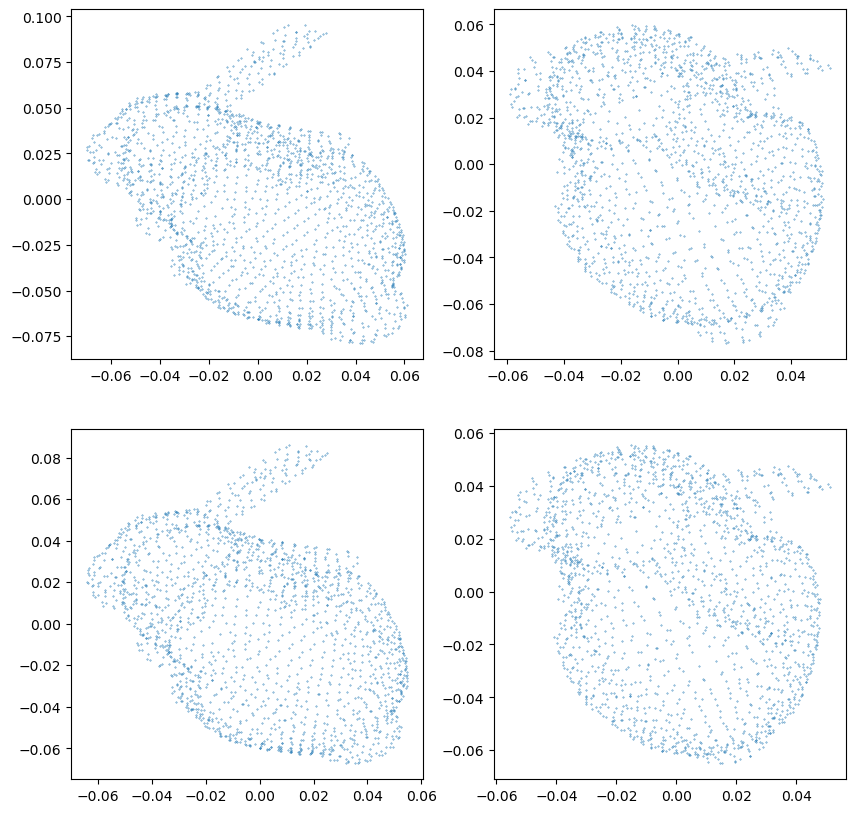

In [339]:
fig2,ax2 = plt.subplots(2,2,figsize = (10,10))
ax2[0,0].scatter(camera_point_list[0][:,0].squeeze().numpy(),camera_point_list[0][:,1].squeeze().numpy(),s = 0.1)
ax2[0,1].scatter(camera_point_list[1][:,0].squeeze().numpy(),camera_point_list[1][:,1].squeeze().numpy(), s= .1)
ax2[1,0].scatter(reconsturcted_1[:,0].squeeze().numpy(),reconsturcted_1[:,1].squeeze().numpy(),s = 0.1)
ax2[1,1].scatter(reconsturcted_2[:,0].squeeze().numpy(),reconsturcted_2[:,1].squeeze().numpy(),s=0.1)

In [340]:
np_recon_1 = reconsturcted_1.squeeze().numpy().T
np_recon_2 = reconsturcted_2.squeeze().numpy().T

In [341]:
np_recon_1.shape

(3, 1889)

1. find centroid of point1 and point2
2. bring point1 and point2 to origin and find Rotation mat
3. find translation t

http://nghiaho.com/?page_id=671

In [342]:
centroid1 = 1/len(np_recon_1) * np.sum(np_recon_1,axis = 1).T
centroid2 = 1/len(np_recon_2) * np.sum(np_recon_2,axis = 1).T

In [343]:
def rigid_transform_3D(A, B):

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [344]:
R,t = rigid_transform_3D(np_recon_1,np_recon_2)

In [345]:
t

array([[0.01698207],
       [0.08121419],
       [0.01779567]])

In [354]:
translated_np_recon1 = (R@np_recon_1+t).T

In [370]:
np.where((translated_np_recon1- np_recon_2.T) > 0.01)

(array([], dtype=int64), array([], dtype=int64))

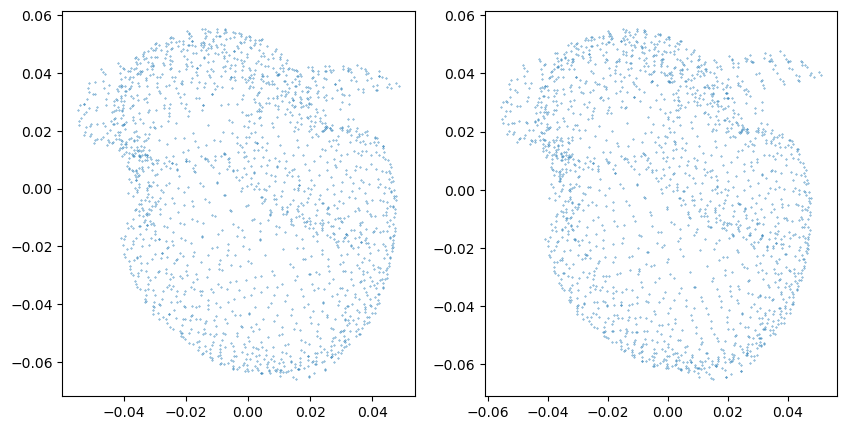

In [355]:
fig3,ax3 = plt.subplots(1,2,figsize = (10,5))
ax3[0].scatter(translated_np_recon1[:,0],translated_np_recon1[:,1],s = 0.1)
ax3[1].scatter(np_recon_2.T[:,0],np_recon_2.T[:,1], s= 0.1)
# ax2[1,0].scatter(reconsturcted_1[:,0].squeeze().numpy(),reconsturcted_1[:,1].squeeze().numpy(),s = 0.1)
# ax2[1,1].scatter(reconsturcted_2[:,0].squeeze().numpy(),reconsturcted_2[:,1].squeeze().numpy(),s=0.1)

In [110]:
tempR = tempT[:9].reshape(3,3)
temptrans = tempT[9:]

In [111]:
(tempR@camera_point_list[0].squeeze().numpy()[1,:]) + temptrans

array([-0.01302003,  0.0158161 ,  0.03479163])

In [102]:
tempT


array([ 0.58269579, -0.61380381,  0.12570808, -0.22263802,  0.57398821,
        0.01358997, -0.05675713, -0.07323814,  0.08564886, -0.0218428 ,
       -0.00321374,  0.01600792])

In [80]:
camera_point_list[1]

tensor([[[-0.0058],
         [ 0.0130],
         [ 0.2328]],

        [[-0.0134],
         [ 0.0178],
         [ 0.2354]],

        [[-0.0541],
         [ 0.0030],
         [ 0.2558]],

        ...,

        [[-0.0070],
         [ 0.0658],
         [ 0.2537]],

        [[-0.0184],
         [ 0.0483],
         [ 0.2485]],

        [[-0.0042],
         [ 0.0248],
         [ 0.2568]]])

In [126]:
p1 = camera_point_list[0].squeeze().numpy()
p2 = camera_point_list[1].squeeze().numpy()
p14 = np.concatenate([p1,np.ones([len(p1),1])],axis = 1)
p24 = np.concatenate([p2,np.ones([len(p2),1])],axis = 1)


In [135]:
temptt = p24[:4,:]@(np.linalg.inv((p14[:4,:]).T))

array([[ 57.54732508,  23.89002338, 136.38178039, -31.73234997],
       [ 62.04947113,  27.61159584, 146.50322241, -34.12736466],
       [ 70.88016863,  34.66065929, 168.2335122 , -39.28055914],
       [ 38.04101528,   7.69890255,  93.91569509, -21.68978932]])

In [134]:
(np.linalg.inv((p14[:4,:]).T))

array([[-378.81961936, -304.84534802, -859.19214317,  203.48801294],
       [ 370.41451167,  314.03067339,  794.89688296, -187.81757286],
       [ -54.91311129,  -35.48552408,  -73.99072826,   17.5171118 ],
       [  63.31821897,   26.30019871,  138.28598847,  -32.18755189]])

In [ ]:
point_distort_xyz_2[:,:2,0].shape

torch.Size([100, 2])

compute fundamental matrix with RANSAC

$x_{2}Fx_{1}$ = 0 

compute Essensial matrix M with F and intrinsic matrices 
$E = \Lambda^{T}_{2}F\Lambda_{1}$

In [40]:
#find fundamental matrix 

# [x2, y2, 1]F[x1,y1,1].T = 0 
#use opencv to find the fundamental matrix and do RANSAC matching
import cv2
F, mask = cv2.findFundamentalMat(points_list[0].numpy(),
                                 points_list[1].numpy(),
                                 cv2.FM_RANSAC)



In [41]:
F

array([[-8.93903291e+05,  2.03351734e+06,  3.89716300e+07],
       [ 2.03365432e+06,  8.93968451e+05,  1.22179987e+07],
       [-4.05934495e+07, -4.49880561e+06,  1.00000000e+00]])

In [42]:
F

array([[-8.93903291e+05,  2.03351734e+06,  3.89716300e+07],
       [ 2.03365432e+06,  8.93968451e+05,  1.22179987e+07],
       [-4.05934495e+07, -4.49880561e+06,  1.00000000e+00]])

In [43]:
E = (camera_K.T).numpy()@F@camera_K.numpy()
# np.linalg.det(E) = 0 True

In [44]:
E

array([[-8.93903291e+05,  2.03351734e+06,  3.89716300e+07],
       [ 2.03365432e+06,  8.93968451e+05,  1.22179987e+07],
       [-4.05934495e+07, -4.49880561e+06,  1.00000000e+00]])

Decompose essential matrix 

$E = \tau_{\times} \Omega$

singular decomposition

$E = ULV^{T} $

$\tau =ULWU^{T} $

$\Omega = UW^{-1}V^{T}$

where: 

$W = \begin{bmatrix}
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix}$

$\tau_{\times} = \begin{bmatrix}
0 & -\tau_{z} & \tau_{y}\\
\tau_{z} & 0 & -\tau_{x}\\
-\tau_{y} & \tau_{x} & 0
\end{bmatrix} 
$
equation 16.10

In [45]:
U,l,vh = np.linalg.svd(E, full_matrices=True, compute_uv=True, hermitian=False)

In [ ]:
l.shape

(3,)

In [46]:
L = np.diag(l)

In [47]:
U@L@vh - E <0.0001 #correct sigular value decomposition 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [48]:
W = np.matrix([[0,1,0],[-1,0,0],[0,0,1]])

In [49]:
tau = U@L@W@(U.T)

In [50]:
omega = U@np.linalg.inv(W)@(vh)

In [51]:
tau@omega - E < 0.0001 

matrix([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

In [52]:
tau

matrix([[-4.05367914e+01,  2.22144217e+06, -3.89716230e+07],
        [-2.22146800e+06, -3.96955646e+00, -1.22179991e+07],
        [ 3.89716302e+07,  1.22179963e+07,  4.45063479e+01]])

In [ ]:
x2 = points_list[1].squeeze().numpy()
x1 = points_list[1].squeeze().numpy()
x2.shape

(1889, 3)

In [ ]:
(x2)@E@(x1.T)

array([[ 0.84794982,  1.18565377,  0.2880233 , ...,  3.97711902,
         2.83319325,  0.70547965],
       [ 0.74858602,  1.07149519,  0.20931309, ...,  3.72710289,
         2.64022859,  0.59745965],
       [ 0.8906442 ,  1.31781314,  0.17104379, ...,  4.8091308 ,
         3.38243917,  0.66686262],
       ...,
       [-0.4997913 , -0.07198808, -1.30718343, ...,  3.12109359,
         1.847446  , -1.05717026],
       [ 0.05516634,  0.41690586, -0.59777266, ...,  3.22105569,
         2.0908259 , -0.30173243],
       [ 0.42083024,  1.01431048, -0.62981715, ...,  5.68689352,
         3.79577951, -0.08561027]])